# Import Required Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load in the raw csv files

In [2]:
# Import datasets
customers = pd.read_csv("../../data/raw/customer.csv")
payments = pd.read_csv("../../data/raw/payment.csv")
rentals = pd.read_csv("../../data/raw/rental.csv")
app_ids = pd.read_csv("../../data/raw/app_id.csv")


In [3]:
# Creating new dataframes with only the columns needed for the analysis
customers_clean = customers[["customer_id"]].copy()
app_ids_clean = app_ids[["customer_id", "android_id", "apple_id"]].copy()
payments_clean = payments[["customer_id", "amount"]].copy()
rentals_clean = rentals[["customer_id", "rental_date", "return_date"]].copy()

In [4]:
# Check if there are customers without any device IDs
no_device = (
    app_ids_clean["apple_id"].isna() & app_ids_clean["android_id"].isna()
)

no_device.sum()  # counts number of True values

# Each customer should have at least one device ID -> returns 0

np.int64(0)

In [5]:
# Creates a new device type column based on the presence of android_id or apple_id
app_ids_clean["device_type"] = app_ids_clean.apply(
    lambda row: "Android" if pd.notna(row["android_id"]) else "Apple", axis=1
)

# Drop the android_id and apple_id columns as they are no longer needed
app_ids_clean = app_ids_clean.drop(columns=["android_id", "apple_id"])

In [6]:
# Checks if there are any null or non-numeric amounts in payments - returns 0
payments_clean["amount"].isna().sum()

np.int64(0)

In [7]:
# Checks for any negative payment amounts - returns empty dataframe, so no negative payments
payments_clean[payments_clean["amount"] < 0]

,customer_id,amount


In [8]:
# No missing rental dates - returns 0
rentals_clean["rental_date"].isna().sum()

np.int64(0)

In [9]:
# Convert rental and return dates to datetime objects
rentals_clean["rental_date"] = pd.to_datetime(rentals_clean["rental_date"])
rentals_clean["return_date"] = pd.to_datetime(rentals_clean["return_date"])

In [10]:
# Calculate rental duration in days
rentals_clean["rental_duration_days"] = (
    rentals_clean["return_date"] - rentals_clean["rental_date"]
).dt.days


In [11]:
# Merging dataframes
device_analysis_df = (
    customers_clean.merge(app_ids_clean, on="customer_id", how="left")
    .merge(payments_clean, on="customer_id", how="left")
    .merge(rentals_clean, on="customer_id", how="left")
)

print("Merged DF:")
print(device_analysis_df.head())

Merged DF:
   customer_id device_type  amount         rental_date         return_date  \
0            1     Android    5.99 2005-05-25 11:30:37 2005-06-03 12:00:37   
1            1     Android    5.99 2005-05-28 10:35:23 2005-06-03 06:32:23   
2            1     Android    5.99 2005-06-15 00:54:12 2005-06-23 02:42:12   
3            1     Android    5.99 2005-06-15 18:02:53 2005-06-19 15:54:53   
4            1     Android    5.99 2005-06-15 21:08:46 2005-06-25 02:26:46   

   rental_duration_days  
0                   9.0  
1                   5.0  
2                   8.0  
3                   3.0  
4                   9.0  


/var/folders/fq/1zk4gbx56g72bmkvx_n6qjw80000gn/T/ipykernel_16565/4246957504.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


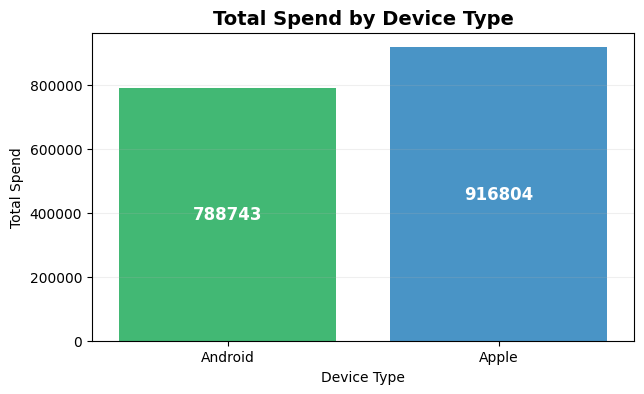

In [12]:
# TOTAL SPEND BY DEVICE TYPE
total_spend = (
    device_analysis_df.groupby("device_type")["amount"]
    .sum()
    .reset_index()
    .rename(columns={"amount": "total_spend"})
)

device_colors = {"Android": "#2ecc71", "Apple": "#3498db"}

plt.figure(figsize=(7, 4))

sns.barplot(
    data=total_spend, x="device_type", y="total_spend", palette=device_colors
)

plt.title("Total Spend by Device Type", fontsize=14, weight="bold")
plt.xlabel("Device Type")
plt.ylabel("Total Spend")
plt.grid(axis="y", alpha=0.2)

# Add numbers centered in bars
for index, row in total_spend.iterrows():
    plt.text(
        x=index,
        y=row["total_spend"] / 2,
        s=f"{row['total_spend']:.0f}",
        ha="center",
        va="center",
        color="white",
        fontsize=12,
        weight="bold",
    )

plt.show()

  device_type  avg_rental_days
0     Android         4.542543
1       Apple         4.531047


/var/folders/fq/1zk4gbx56g72bmkvx_n6qjw80000gn/T/ipykernel_16565/4012694656.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


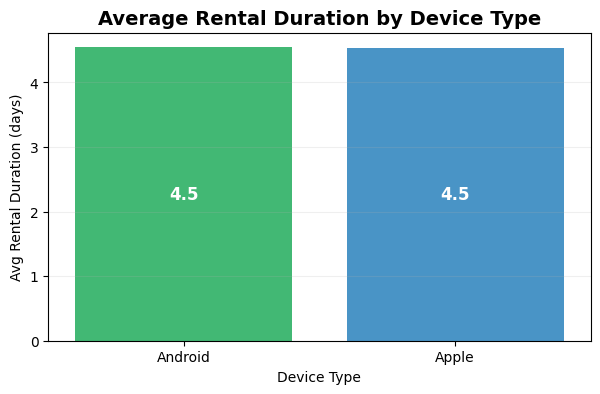

In [13]:
# AVERAGE RENTAL DURATION (IN DAYS)

# Calculates rental duration
device_analysis_df["rental_duration"] = (
    device_analysis_df["return_date"] - device_analysis_df["rental_date"]
).dt.days

# Groups by device type
avg_rental_time = (
    device_analysis_df.groupby("device_type")["rental_duration"]
    .mean()
    .reset_index()
    .rename(columns={"rental_duration": "avg_rental_days"})
)

print(avg_rental_time)

device_colors = {"Android": "#2ecc71", "Apple": "#3498db"}

plt.figure(figsize=(7, 4))

sns.barplot(
    data=avg_rental_time,
    x="device_type",
    y="avg_rental_days",
    palette=device_colors,
)

plt.title("Average Rental Duration by Device Type", fontsize=14, weight="bold")
plt.xlabel("Device Type")
plt.ylabel("Avg Rental Duration (days)")
plt.grid(axis="y", alpha=0.2)

# Add values in bars
for index, row in avg_rental_time.iterrows():
    plt.text(
        x=index,
        y=row["avg_rental_days"] / 2,
        s=f"{row['avg_rental_days']:.1f}",
        ha="center",
        va="center",
        color="white",
        fontsize=12,
        weight="bold",
    )

plt.show()

  device_type  total_spend  rental_count  avg_payment_per_rental
0     Android    788743.28        187872                4.198301
1       Apple    916803.57        217443                4.216294


/var/folders/fq/1zk4gbx56g72bmkvx_n6qjw80000gn/T/ipykernel_16565/2750625334.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


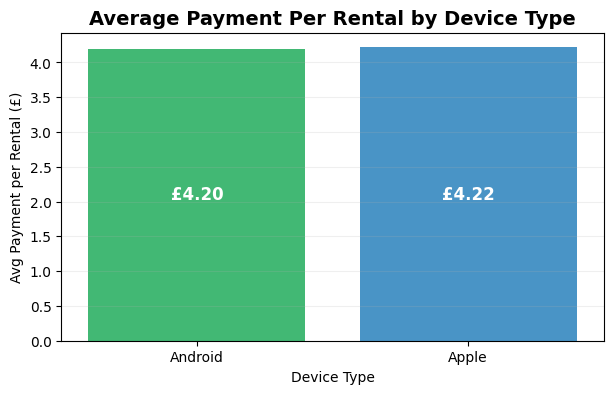

In [ ]:
# AVERAGE PAYMENT PER RENTAL BY DEVICE

# Rentals count per device
rental_counts = (
    device_analysis_df.groupby("device_type")["rental_date"]
    .count()
    .reset_index()
    .rename(columns={"rental_date": "rental_count"})
)

# Total spend per device
spend = (
    device_analysis_df.groupby("device_type")["amount"]
    .sum()
    .reset_index()
    .rename(columns={"amount": "total_spend"})
)

# Merge rental counts and total spend
avg_payment_per_rental = spend.merge(rental_counts, on="device_type")

avg_payment_per_rental["avg_payment_per_rental"] = (
    avg_payment_per_rental["total_spend"]
    / avg_payment_per_rental["rental_count"]
)

print(avg_payment_per_rental)

# Colours for each device type
device_colors = {"Android": "#2ecc71", "Apple": "#3498db"}

# Graph of average payment per rental by device
plt.figure(figsize=(7, 4))
sns.barplot(
    data=avg_payment_per_rental,
    x="device_type",
    y="avg_payment_per_rental",
    palette=device_colors
)

plt.title(
    "Average Payment Per Rental by Device Type", fontsize=14, weight="bold"
)
plt.xlabel("Device Type")
plt.ylabel("Avg Payment per Rental")

# Add text labels inside bars
for index, row in avg_payment_per_rental.iterrows():
    plt.text(
        x=index,
        y=row["avg_payment_per_rental"] / 2,
        s=f"£{row['avg_payment_per_rental']:.2f}",
        ha="center",
        va="center",
        color="white",
        fontsize=12,
        weight="bold",
    )

plt.grid(axis="y", alpha=0.2)
plt.show()